In [22]:
import os
from PIL import Image
from IPython.display import Image as ImageDisplay
from torchvision import transforms
import numpy as np
import torch
from tqdm.notebook import tqdm, trange
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, chi2
from pprint import pprint
import pickle
import warnings
warnings.filterwarnings("ignore")

In [2]:
IMG_HEIGHT = 512  
IMG_WIDTH = 1024
TOTAL_CLASS = 19
INDEX = 0

In [3]:
id2class = {
     255 : "unlabeled",
     0 : "road",
     1 : "sidewalk",
     2 : "building",
     3 : "wall",
     4 : "fence",
     5 : "pole",
     6 : "traffic light",
     7 : "traffic sign",
     8 : "vegetation",
     9 : "terrain",
    10 : "sky",
    11 : "person",
    12 : "rider",
    13 : "car",
    14 : "truck",
    15 : "bus",
    16 : "train",
    17 : "motorcycle",
    18 : "bicycle"
}

In [4]:
color_mapping_after_conversion = {
     255 : (  0,  0,  0),
     0 : (128, 64,128),
     1 : (244, 35,232),
     2 : ( 70, 70, 70),
     3 : (102,102,156),
     4 : (190,153,153),
     5 : (153,153,153),
     6 : (250,170, 30),
     7 : (220,220,  0),
     8 : (107,142, 35),
     9 : (152,251,152),
    10 : ( 70,130,180),
    11 : (220, 20, 60),
    12 : (255,  0,  0),
    13 : (  0,  0,142),
    14 : (  0,  0, 70),
    15 : (  0, 60,100),
    16 : (  0, 80,100),
    17 : (  0,  0,230),
    18 : (119, 11, 32)
}

In [5]:
root_dir = 'data'
mode = 'gtFine'
split = 'train'

label_path = os.path.join(os.getcwd(), root_dir+'/' + mode + '/'+ split)
rgb_path = os.path.join(os.getcwd(), root_dir + '/leftImg8bit/' + split)
city_list = os.listdir(label_path)

In [6]:
label_path, rgb_path, city_list

('/Users/dipta007/my-world/SeeBel/A3/data/gtFine/train',
 '/Users/dipta007/my-world/SeeBel/A3/data/leftImg8bit/train',
 ['zurich',
  'strasbourg',
  'weimar',
  'aachen',
  'tubingen',
  'jena',
  'bochum',
  'darmstadt',
  'dusseldorf',
  'hamburg',
  'cologne',
  'monchengladbach',
  'krefeld',
  'ulm',
  'hanover',
  'stuttgart',
  'erfurt',
  'bremen'])

In [7]:
XImg_list = []
yLabel_list = []

for city in city_list:
  XImg_list.extend(
        ['/' + city + '/' + path for path in os.listdir(rgb_path + '/' + city)]
    )
for i in range(len(XImg_list)):
  yLabel_list.append(XImg_list[i][:-15] + "gtFine_labelIds.png")

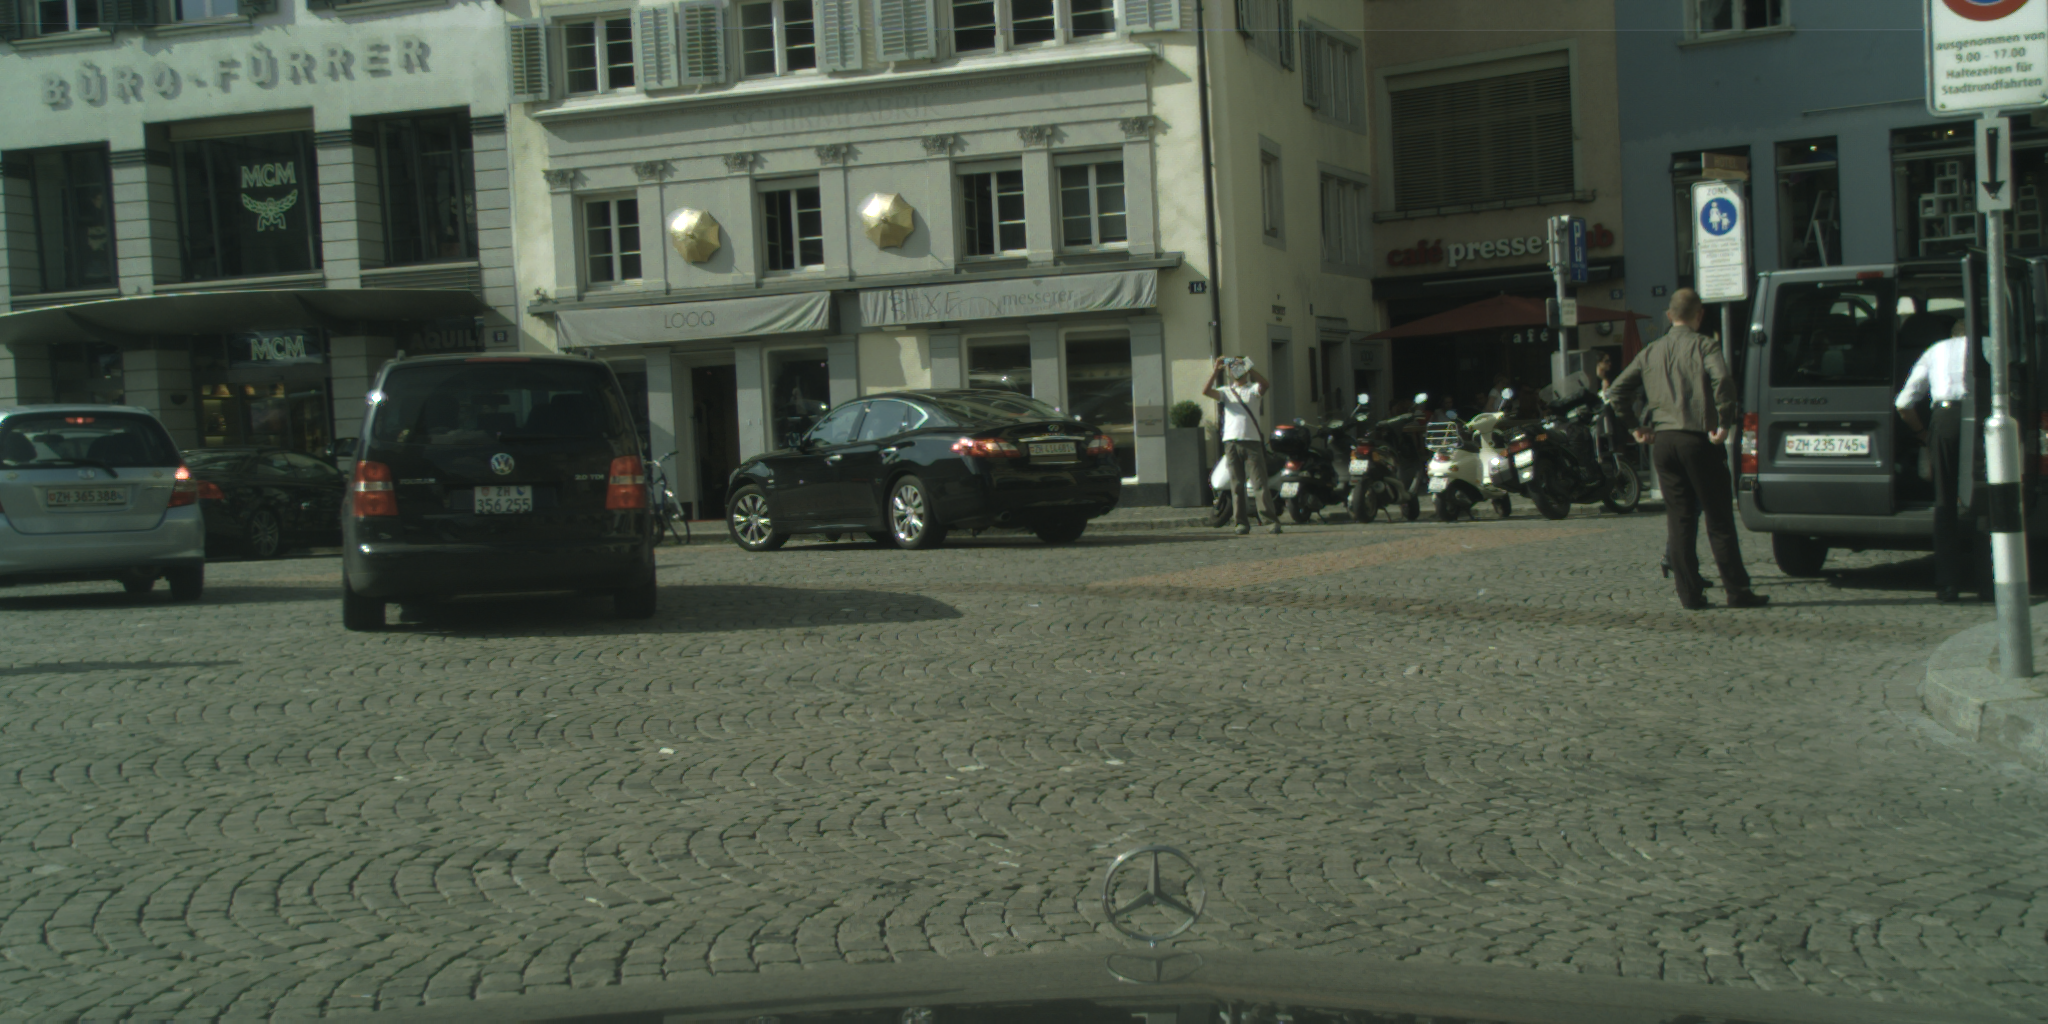

In [8]:
ImageDisplay(filename=rgb_path + XImg_list[INDEX]) 

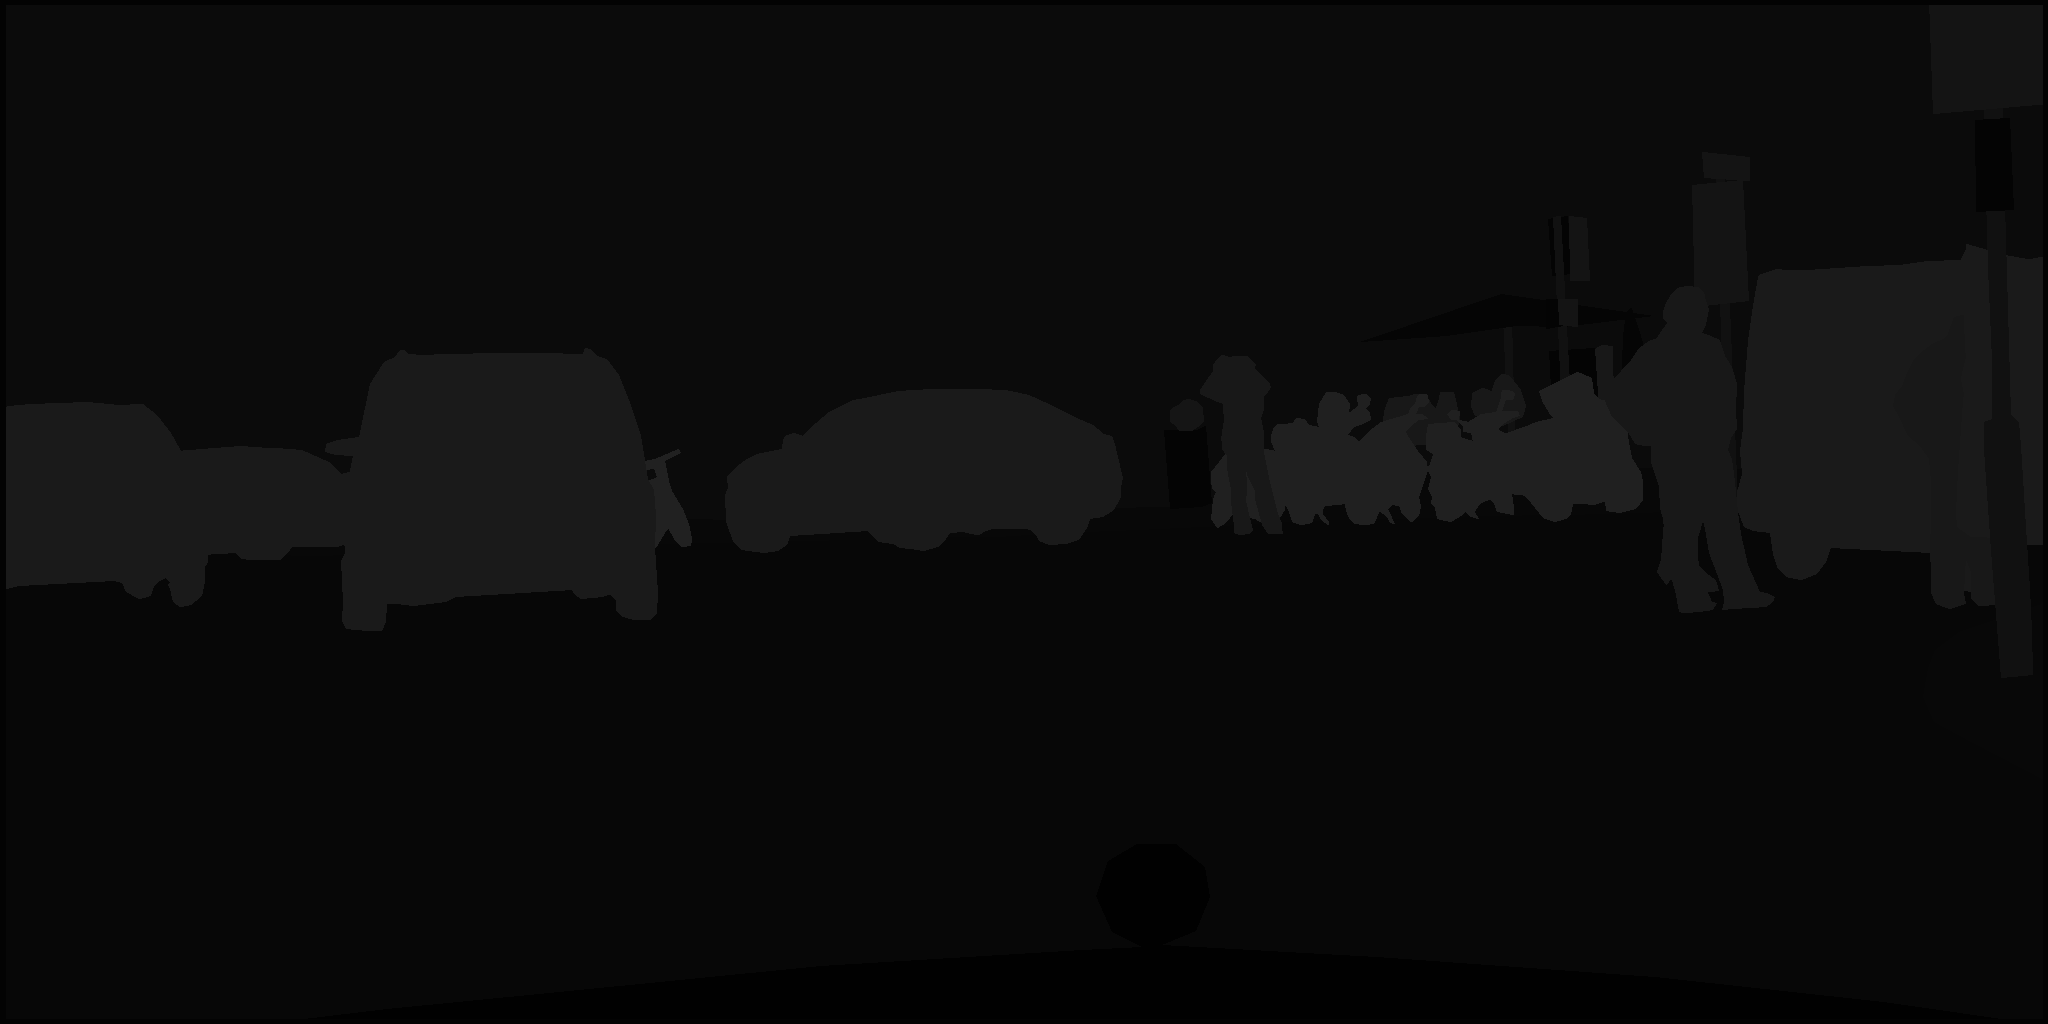

In [9]:
ImageDisplay(filename=label_path + yLabel_list[INDEX])

In [10]:
label_mapping = {-1: 255, 0: 255, 
                  1: 255, 2: 255, 
                  3: 255, 4: 255, 
                  5: 255, 6: 255, 
                  7: 0, 8: 1, 9: 255, 
                  10: 255, 11: 2, 12: 3, 
                  13: 4, 14: 255, 15: 255, 
                  16: 255, 17: 5, 18: 255, 
                  19: 6, 20: 7, 21: 8, 22: 9, 23: 10, 24: 11,
                  25: 12, 26: 13, 27: 14, 28: 15, 
                  29: 255, 30: 255, 
                  31: 16, 32: 17, 33: 18}

selected_labels = [0, 2, 6, 10, 11, 13]
selected_labels = [6, 10, 11, 13]

def refine_label(label):
  label[label < -1] = 0
  label[label > 33] = 0
  return label
  
def convert_label(label):
  for k, v in label_mapping.items():
    if v in selected_labels:
      label[label == k] = v
    else:
      label[label == k] = 255
  label[label < 0] = 255
  label[label > 18] = 255
  return label

In [11]:
def get_data(index):
  image = Image.open(rgb_path + XImg_list[index])
  image = transforms.ToTensor()(image)
  i_r = image[0, :, :].flatten()
  i_g = image[1, :, :].flatten()
  i_b = image[2, :, :].flatten()
  
  y = Image.open(label_path + yLabel_list[index])
  y = np.array(y)
  y = torch.from_numpy(y)
  y = y.type(torch.LongTensor)
  y = convert_label(y)
  y = y.flatten()
  
  labels_present = torch.unique(y).tolist()
  groups = {}
  for l in labels_present:
    if l == 255:
      continue
    indices = (y == l).nonzero(as_tuple=True)
    groups[l] = torch.cat((i_r[indices], i_g[indices], i_b[indices]))
  return groups

In [12]:
groups = [[] for _ in range(TOTAL_CLASS)]

for i in trange(len(XImg_list)):
  curr_grp = get_data(i)
  for k, v in curr_grp.items():
    groups[k].append(v)
  if i == 200: break

print([(i, len(groups[i])) for i in range(TOTAL_CLASS)])

  0%|          | 0/2975 [00:00<?, ?it/s]

[(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 112), (7, 0), (8, 0), (9, 0), (10, 183), (11, 171), (12, 0), (13, 190), (14, 0), (15, 0), (16, 0), (17, 0), (18, 0)]


## Generic Function to plot

In [13]:
jitter = {
  6: (4,4),
  10: (-4, 4),
  11: (4, -4),
  13: (-4, -4)
}

def get_figure(pca_groups, title=""):
  fig, axs = plt.subplots(figsize=(10, 8), nrows=1, ncols=2) 

  for idx in [13, 10, 11, 6]:
    X_PCA = pca_groups[idx]
    
    x, y = X_PCA[:, 0], X_PCA[:, 1]
    
    ax = axs[0]
    ax.plot(x, y, marker='o', linestyle='', ms=5, label=id2class[idx], mec='none')
    ax.set_aspect('auto')
    ax.set_xlabel("Principal Component 1")
    ax.set_ylabel("Principal Component 2")
    ax.legend()
    ax.set_title("Raw Data with PCA (No noise)")
    
    x = x + jitter[idx][0]
    y = y + jitter[idx][1]
    
    ax = axs[1]
    ax.plot(x, y, marker='o', linestyle='', ms=5, label=id2class[idx], mec='none')
    ax.set_aspect('auto')
    ax.set_xlabel("Principal Component 1")
    ax.set_ylabel("Principal Component 2")
    ax.legend()
    ax.set_title("Raw Data with PCA (added noise to show proper cluster)")
  
  fig.suptitle(title, fontsize=16, wrap=True)
  fig.tight_layout()
  plt.show()

## Truncation at end, then PCA

  0%|          | 0/19 [00:00<?, ?it/s]

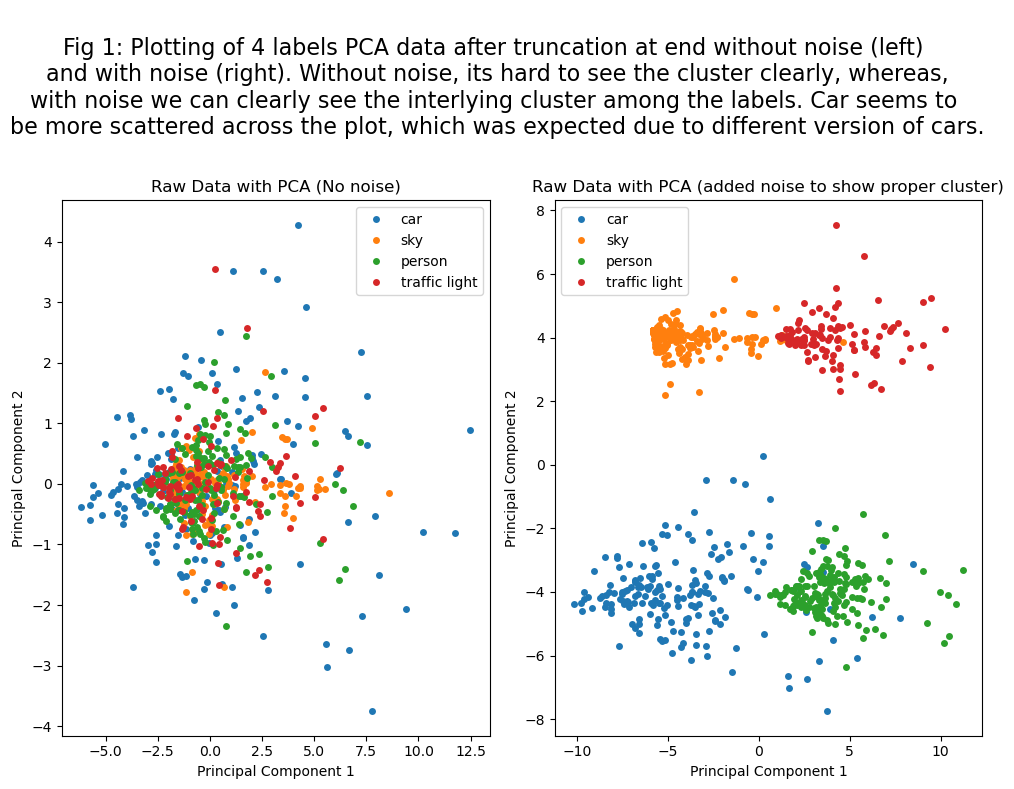

In [14]:
pca_groups = {}

for l in trange(TOTAL_CLASS):
  if len(groups[l]) == 0:
    continue
  mn = min([groups[l][i].shape[0] for i in range(len(groups[l]))])
  truncated_grp = []
  for v in groups[l]:
    nv = v[:mn]
    truncated_grp.append(np.array(nv))
  truncated_grp = np.array(truncated_grp)
  pca = PCA(2)
  x = pca.fit_transform(truncated_grp)
  pca_groups[l] = x
  
  
caption = """
Fig 1: Plotting of 4 labels PCA data after truncation at end without noise (left) 
and with noise (right). Without noise, its hard to see the cluster clearly, whereas,
with noise we can clearly see the interlying cluster among the labels. Car seems to 
be more scattered across the plot, which was expected due to different version of cars.
"""
get_figure(pca_groups, caption)

## Truncation at start, then PCA

  0%|          | 0/19 [00:00<?, ?it/s]

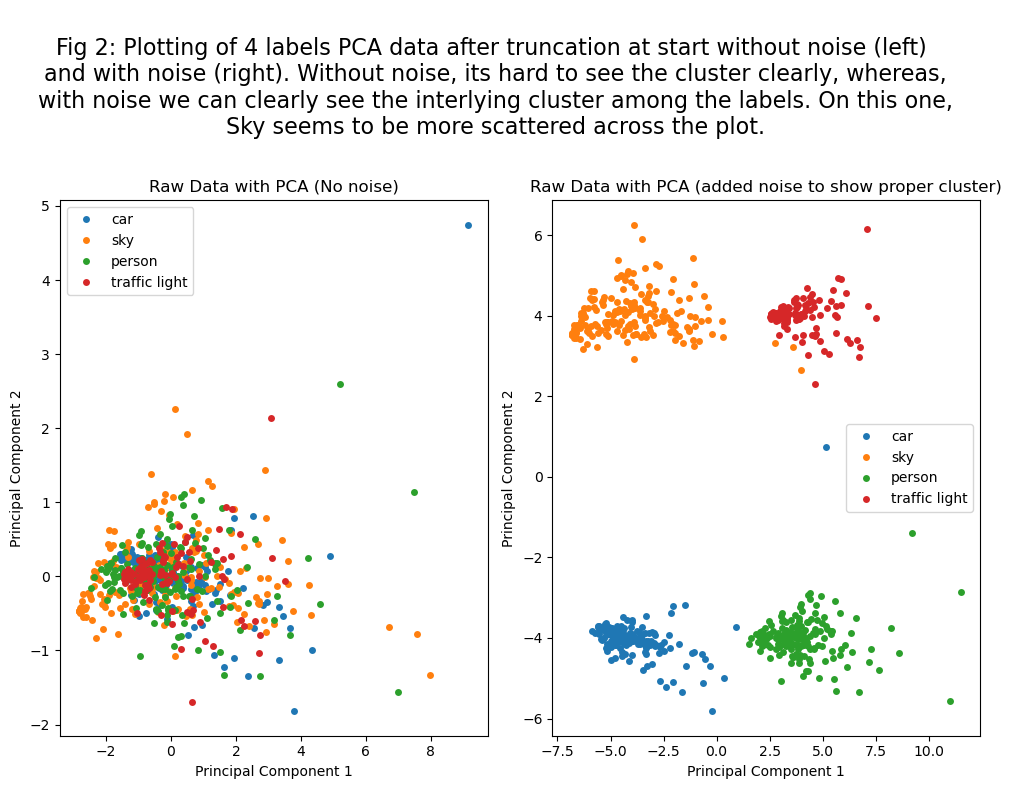

In [15]:
pca_groups = {}

for l in trange(TOTAL_CLASS):
  if len(groups[l]) == 0:
    continue
  mn = min([groups[l][i].shape[0] for i in range(len(groups[l]))])
  truncated_grp = []
  for v in groups[l]:
    nv = v[v.shape[0]-mn:]
    truncated_grp.append(np.array(nv))
  truncated_grp = np.array(truncated_grp)
  pca = PCA(2)
  x = pca.fit_transform(truncated_grp)
  pca_groups[l] = x
  
caption = """
Fig 2: Plotting of 4 labels PCA data after truncation at start without noise (left) 
and with noise (right). Without noise, its hard to see the cluster clearly, whereas,
with noise we can clearly see the interlying cluster among the labels. On this one,
Sky seems to be more scattered across the plot.
"""
get_figure(pca_groups, caption)

## Padding at end, then PCA

  0%|          | 0/19 [00:00<?, ?it/s]

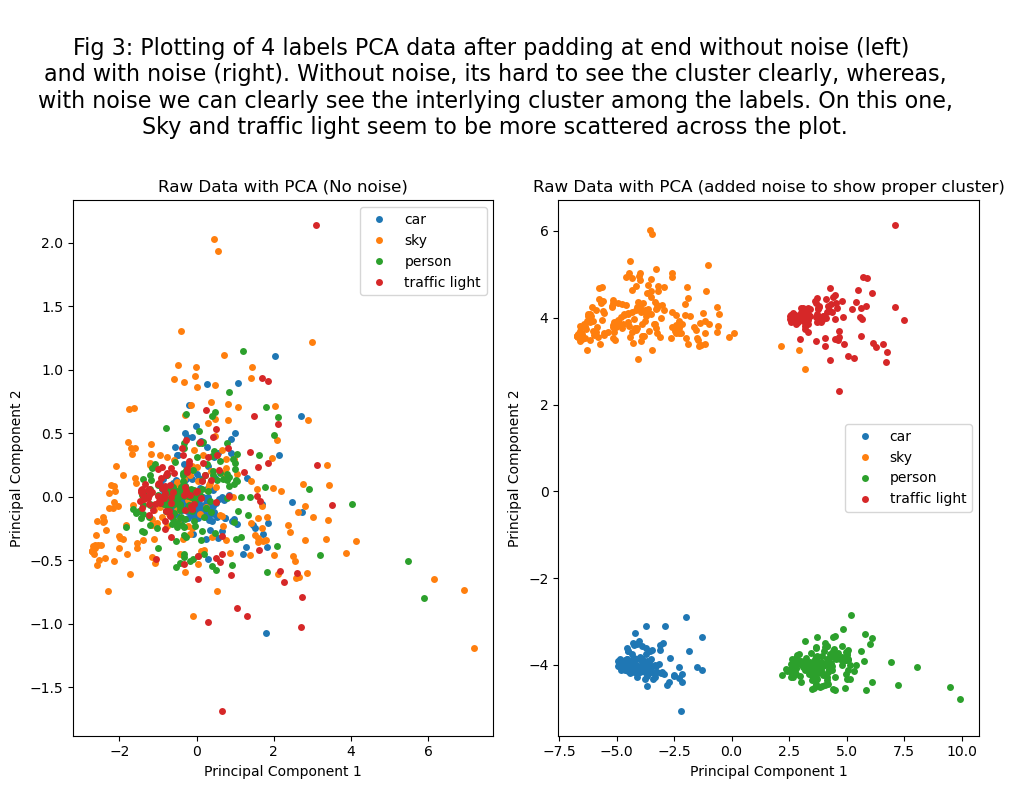

In [24]:
pca_groups = {}

for l in trange(TOTAL_CLASS):
  if len(groups[l]) == 0:
    continue
  mx = max([groups[l][i].shape[0] for i in range(len(groups[l]))])
  truncated_grp = []
  for v in groups[l]:
    nv = v[v.shape[0]-mn:]
    pad_by = mx - nv.shape[0]
    nv = torch.nn.functional.pad(nv, (0, pad_by))
    truncated_grp.append(np.array(nv))
  truncated_grp = np.array(truncated_grp)
  pca = PCA(2)
  x = pca.fit_transform(truncated_grp)
  pca_groups[l] = x

caption = """
Fig 3: Plotting of 4 labels PCA data after padding at end without noise (left) 
and with noise (right). Without noise, its hard to see the cluster clearly, whereas,
with noise we can clearly see the interlying cluster among the labels. On this one,
Sky and traffic light seem to be more scattered across the plot.
"""
get_figure(pca_groups, caption)

## Padding at start, then PCA

  0%|          | 0/19 [00:00<?, ?it/s]

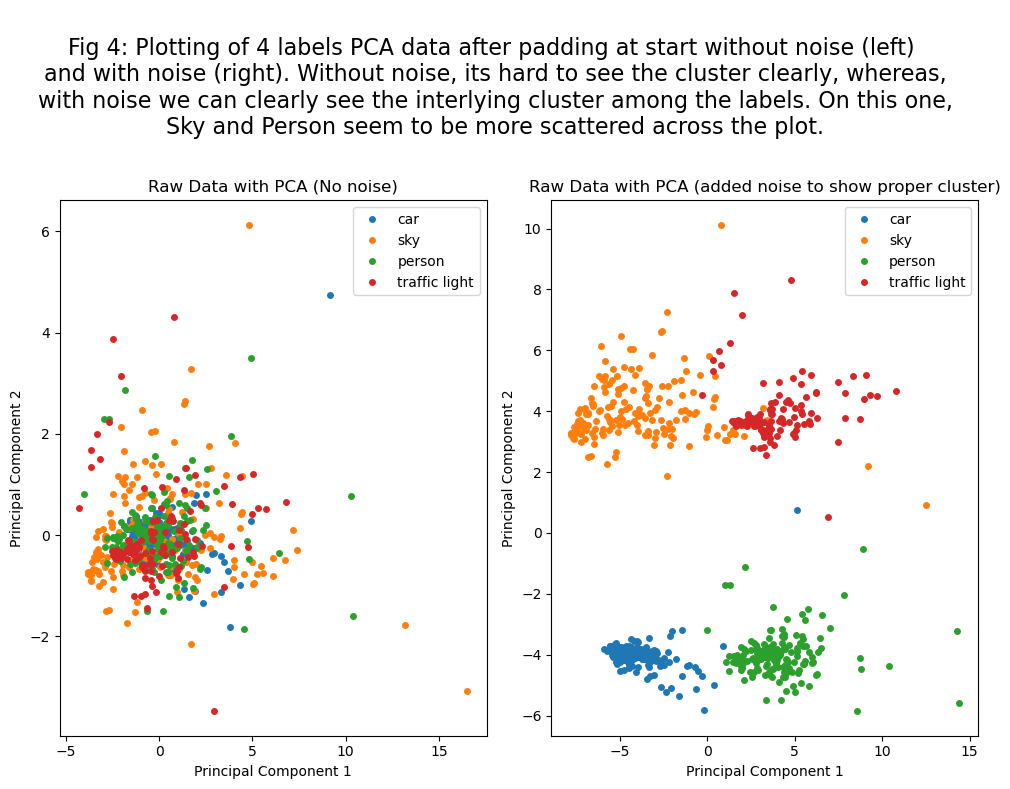

In [17]:
pca_groups = {}

for l in trange(TOTAL_CLASS):
  if len(groups[l]) == 0:
    continue
  mx = max([groups[l][i].shape[0] for i in range(len(groups[l]))])
  truncated_grp = []
  for v in groups[l]:
    nv = v[v.shape[0]-mn:]
    pad_by = mx - nv.shape[0]
    nv = torch.nn.functional.pad(nv, (pad_by, 0))
    truncated_grp.append(np.array(nv))
  truncated_grp = np.array(truncated_grp)
  pca = PCA(2)
  x = pca.fit_transform(truncated_grp)
  pca_groups[l] = x
  
caption = """
Fig 4: Plotting of 4 labels PCA data after padding at start without noise (left) 
and with noise (right). Without noise, its hard to see the cluster clearly, whereas,
with noise we can clearly see the interlying cluster among the labels. On this one,
Sky and Person seem to be more scattered across the plot.
"""
get_figure(pca_groups, caption)

## Feature Extraction to make same size, then PCA

In [18]:
pca_groups = {}

mx = 0
mn = int(2e9)
for l in trange(TOTAL_CLASS):
  if len(groups[l]) == 0: continue
  for i in range(len(groups[l])):
    mx = max(mx, groups[l][i].shape[0])
    mn = min(mn, groups[l][i].shape[0])
print("MAX:", mx)
print("MIN:", mn)

for l in trange(TOTAL_CLASS):
  if len(groups[l]) == 0:
    continue
  
  truncated_grp = []
  for v in groups[l]:
    nv = v[v.shape[0]-mn:]
    pad_by = mx - nv.shape[0]
    nv = torch.nn.functional.pad(nv, (0, pad_by))
    truncated_grp.append(np.array(nv))
  truncated_grp = np.array(truncated_grp)
  pca_groups[l] = truncated_grp
  
X, Y = [], []
for l in trange(TOTAL_CLASS):
  if l not in pca_groups: continue
  X.extend(pca_groups[l])
  Y.extend([l for _ in range(pca_groups[l].shape[0])])
  
X, Y = torch.tensor(X), torch.tensor(Y)
X.shape, Y.shape

  0%|          | 0/19 [00:00<?, ?it/s]

MAX: 1847238
MIN: 141


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

(torch.Size([656, 1847238]), torch.Size([656]))

In [19]:
X_new = SelectKBest(chi2, k=mn).fit_transform(X, Y)
X_new.shape

(656, 141)

In [20]:
pca_groups = {}

for l in range(TOTAL_CLASS):
  indices = (Y == l).nonzero(as_tuple=True)
  if len(indices[0]) == 0: continue
  curr_x = np.array(X_new[indices[0]])
  pca = PCA(2)
  curr_x = pca.fit_transform(curr_x)
  pca_groups[l] = X_new[indices[0]]

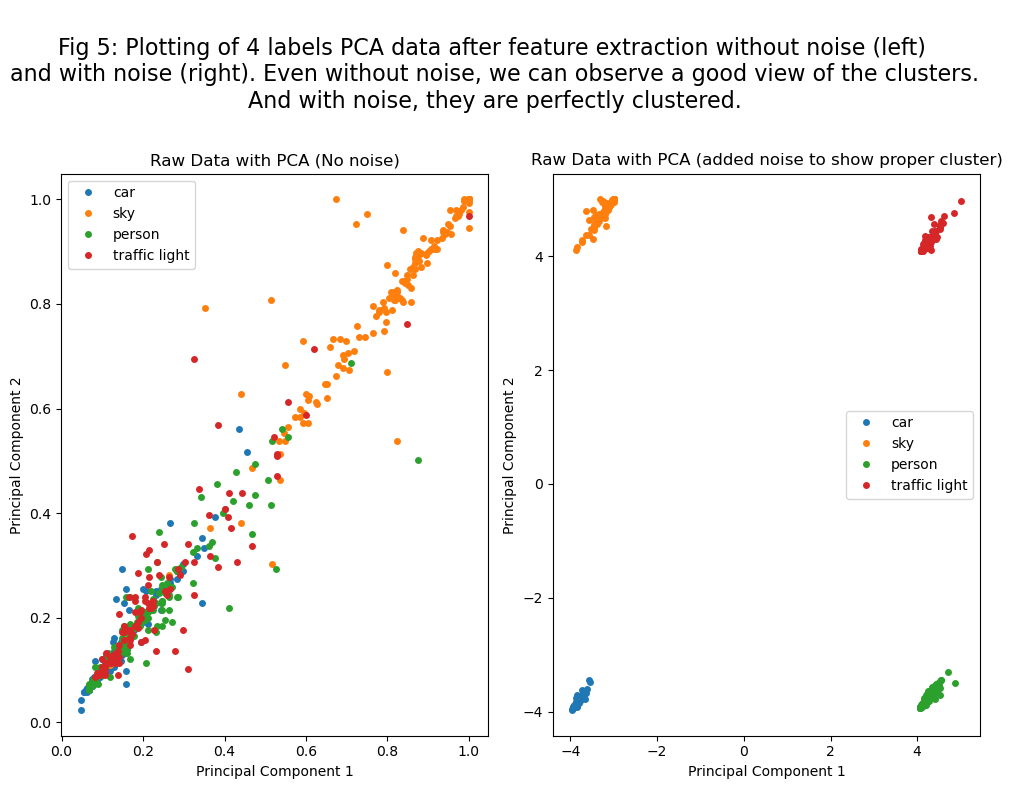

In [21]:
caption = """
Fig 5: Plotting of 4 labels PCA data after feature extraction without noise (left) 
and with noise (right). Even without noise, we can observe a good view of the clusters.
And with noise, they are perfectly clustered.
"""
get_figure(pca_groups, caption)